# Point-A Reference Plan Optimization (v0.3)

This notebook revisits the previous `point_a_plan` workflow and adds a cvxpy-based dwell-time optimizer.
Tandem reference points stay pinned at 100% of the prescription, ovoid surface points are capped at 140%, and ovoid 5 mm depth points must respect an EBRT+BT cumulative EQD2 <= 85 Gy (alpha/beta = 3).
The steps below load the brachy plan, assemble TG-43 influence matrices at the reference points, and solve a convex program that minimally perturbs the plan dwell times while satisfying those dose/EQD2 requirements.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import copy

import SimpleITK as sitk

from pathlib import Path
from collections import defaultdict
from typing import Any, Dict, Iterable, List, Tuple, Sequence

from dataclasses import dataclass, replace
from itertools import product

try:
    from IPython.display import display
except ImportError:  # pragma: no cover - fallback when running as a script
    def display(obj):
        print(obj)

from omegaconf import DictConfig, OmegaConf
from scipy.ndimage import gaussian_filter

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils
import tg43.visualization as vis

import tg43.rtstruct_export as rtexport
import src.dataloader as dataloader

In [2]:
def load_hyperparams(config_path: Path) -> DictConfig:
    """Load run-time hyperparameters from YAML."""
    cfg = OmegaConf.load(config_path)
    return cfg


def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first existing path from ``path_iterable``."""
    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]


def load_case_paths(root: Path, case_id: Path) -> Dict[str, Path]:
    """Collect CT/RTDICOM paths for a given case identifier."""
    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [3]:
def get_reference_point(dose_ref_points: Dict[str, Any], label: str) -> Dict[str, Any]:
    for entry in dose_ref_points:
        if entry["description"].strip().lower() == label.lower():
            return entry
    raise ValueError(f"{label} reference point not found in RTPLAN.")


def filter_redundant_positions(positions: Iterable[np.ndarray]) -> np.ndarray:
    seen = set()
    unique = []
    for pos in positions:
        if pos is None:
            continue
        arr = np.asarray(pos, dtype=float)
        key = tuple(arr.tolist())
        if key in seen:
            continue
        seen.add(key)
        unique.append(arr)
    if not unique:
        return np.zeros((0, 3), dtype=float)
    return np.vstack(unique)


def compute_reference_point_clouds(
    rt_channels,
    aux_points: Dict[str, Any],
) -> Dict[str, np.ndarray]:
    """Return left/right ovoid and tandem reference point sets in centimetres."""
    if len(rt_channels) < 3:
        raise ValueError("Expected at least 3 channels (left/right ovoid + tandem).")

    pos_ovoid_left = filter_redundant_positions(rt_channels[0].positions_cm)
    pos_ovoid_right = filter_redundant_positions(rt_channels[1].positions_cm)
    pos_tandem = filter_redundant_positions(rt_channels[2].positions_cm)

    if not pos_ovoid_left.size or not pos_ovoid_right.size or not pos_tandem.size:
        raise ValueError("Missing dwell positions for ovoid/tandem channels.")

    if '13' in aux_points["rtplan_description"]:
        offset_to_ovoid_surface = 0.75
        offset_over_ovoid_surface = 0.5
        offset_tandem = 2.0
    else: # other cases
        offset_to_ovoid_surface = 0.8
        offset_over_ovoid_surface = 0.5
        offset_tandem = 2.0

    alt_point = get_reference_point(aux_points["dose_reference_points"], "Alt")
    art_point = get_reference_point(aux_points["dose_reference_points"], "Art")
    pos_a_left = np.asarray(alt_point["positions_cm"], dtype=float)
    pos_a_right = np.asarray(art_point["positions_cm"], dtype=float)

    def _unit_vector(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm <= 0.0:
            raise ValueError("Encountered zero-length vector while normalising reference axes.")
        return vec / norm

    ovoid_center = (np.mean(pos_ovoid_right, axis=0) + np.mean(pos_ovoid_left, axis=0)) / 2
    ovoid_axis = np.mean(pos_ovoid_right, axis=0) - np.mean(pos_ovoid_left, axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]

    ovoid_dir = _unit_vector(ovoid_axis)
    tandem_dir = _unit_vector(tandem_axis)
    dot_val = float(np.clip(np.dot(ovoid_dir, tandem_dir), -1.0, 1.0))
    angle_deg = np.degrees(np.arccos(dot_val))
    print(f"Angle between ovoid and tandem axes: {angle_deg:.2f} deg")

    ref_ovoid_surface_left = pos_ovoid_left - (ovoid_dir * offset_to_ovoid_surface)
    ref_ovoid_surface_right = pos_ovoid_right + (ovoid_dir * offset_to_ovoid_surface)
    ref_ovoid_left = pos_ovoid_left - (ovoid_dir * (offset_to_ovoid_surface + offset_over_ovoid_surface))
    ref_ovoid_right = pos_ovoid_right + (ovoid_dir * (offset_to_ovoid_surface + offset_over_ovoid_surface))

    ref_tandem_left = pos_tandem - (ovoid_dir * offset_tandem)
    ref_tandem_right = pos_tandem + (ovoid_dir * offset_tandem)

    threshold_distance = 0.5
    mask = np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance
    ref_tandem_left = ref_tandem_left[mask]
    ref_tandem_right = ref_tandem_right[mask]

    def _filter_by_point_a(ref_pts: np.ndarray, point_a: np.ndarray) -> np.ndarray:
        if ref_pts.shape[0] < 2:
            return ref_pts
        delta_cm = ref_pts - point_a
        axis = ref_pts[-1] - ref_pts[0]
        axis_norm = np.linalg.norm(axis)
        if axis_norm <= 0.0:
            return ref_pts
        axis = axis / axis_norm
        proj_mm = (delta_cm @ axis) * 10.0
        keep = proj_mm <= 5.0
        return ref_pts[keep]

    ref_tandem_left = _filter_by_point_a(ref_tandem_left[1:], pos_a_left)
    ref_tandem_right = _filter_by_point_a(ref_tandem_right[1:], pos_a_right)

    def _slice_points(points: np.ndarray) -> np.ndarray:
        if points.shape[0] >= 3:
            return points[1:3]
        if points.shape[0] <= 1:
            return points
        return points[1:]

    ovoid_surface_left = _slice_points(ref_ovoid_surface_left)
    ovoid_surface_right = _slice_points(ref_ovoid_surface_right)
    ovoid_5mm_left = _slice_points(ref_ovoid_left)
    ovoid_5mm_right = _slice_points(ref_ovoid_right)

    return {
        "ovoid_surface_left": ovoid_surface_left,
        "ovoid_surface_right": ovoid_surface_right,
        "ovoid_5mm_left": ovoid_5mm_left,
        "ovoid_5mm_right": ovoid_5mm_right,
        "ref_tandem_left": ref_tandem_left,
        "ref_tandem_right": ref_tandem_right,
    }


def compute_influence_matrix(
    dwells: List[dosecal.DwellPoint],
    ref_points_cm: np.ndarray,
    tables: dosecal.TG43TableSet,
) -> np.ndarray:
    pts = np.asarray(ref_points_cm, dtype=float)
    if pts.size == 0:
        return np.zeros((0, len(dwells)))
    influence = np.zeros((pts.shape[0], len(dwells)))
    for idx, dwell in enumerate(dwells):
        influence[:, idx] = (
            dosecal.compute_tg43_dose_at_points(
                [dwell], pts, tables, dwell_time_override_s=1.0
            )  # convert Gy per second to cGy per second
        )
    return influence


def build_reference_constraints(
    ref_sets: Dict[str, np.ndarray],
    dwells: List[dosecal.DwellPoint],
    tables: dosecal.TG43TableSet,
    prescription_dose_cgy: float,
) -> Tuple[Dict[str, Dict[str, Any]], List[Dict[str, Any]]]:
    def _group_from_label(label: str) -> str:
        name = label.lower()
        if "tandem" in name:
            return "tandem"
        if "surface" in name:
            return "ovoid_surface"
        if "5mm" in name:
            return "ovoid_5mm"
        raise ValueError(f"Unable to classify reference label '{label}'.")

    specs = {
        "tandem": {"target_scale": 1.0, "sense": "lower_bound"},
        "ovoid_surface": {"target_scale": 1.4, "sense": "upper_bound"},
        "ovoid_5mm": {"sense": "eqd2_upper"},
    }
    grouped: Dict[str, Dict[str, Any]] = defaultdict(
        lambda: {"matrix_rows": [], "targets": [], "rows": []}
    )
    rows: List[Dict[str, Any]] = []
    for label, points in ref_sets.items():
        pts = np.asarray(points, dtype=float)
        if pts.size == 0:
            continue
        group = _group_from_label(label)
        influence = compute_influence_matrix(dwells, pts, tables)
        entry = grouped[group]
        entry["matrix_rows"].append(influence)
        target_val = None
        target_scale = specs[group].get("target_scale")
        if target_scale is not None:
            target_val = prescription_dose_cgy * target_scale
            entry["targets"].append(np.full(pts.shape[0], target_val))
        for idx in range(pts.shape[0]):
            record = {
                "group": group,
                "subset": label,
                "point_index": idx,
                "point_cm": pts[idx].tolist(),
                "constraint_kind": specs[group]["sense"],
                "target_dose_cgy": target_val if target_val is not None else float("nan"),
            }
            entry["rows"].append(record)
            rows.append(record)

    constraint_groups: Dict[str, Dict[str, Any]] = {}
    for group, entry in grouped.items():
        matrix = (
            np.vstack(entry["matrix_rows"]) if entry["matrix_rows"] else np.zeros((0, len(dwells)))
        )
        targets = (
            np.concatenate(entry["targets"]) if entry["targets"] else None
        )
        constraint_groups[group] = {
            "matrix": matrix,
            "target": targets,
            "rows": entry["rows"],
        }
    return constraint_groups, rows
@dataclass
class ApplicatorFrame:
    rotation: np.ndarray
    translation_mm: np.ndarray
    anchor_mm: np.ndarray
    description: str = "ECS"

    @property
    def inverse_rotation(self) -> np.ndarray:
        return self.rotation.T

    def transform_points_mm(self, pts_mm):
        arr = np.asarray(pts_mm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        orig_shape = arr.shape
        arr = arr.reshape(-1, 3)
        transformed = (self.rotation @ arr.T).T + self.translation_mm
        return transformed.reshape(orig_shape)

    def inverse_transform_points_mm(self, pts_mm):
        arr = np.asarray(pts_mm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        orig_shape = arr.shape
        arr = arr.reshape(-1, 3)
        restored = (self.inverse_rotation @ (arr - self.translation_mm).T).T
        return restored.reshape(orig_shape)

    def transform_points_cm(self, pts_cm):
        arr = np.asarray(pts_cm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        return self.transform_points_mm(arr * 10.0) / 10.0

    def inverse_transform_points_cm(self, pts_cm):
        arr = np.asarray(pts_cm, dtype=float)
        if arr.size == 0:
            return arr.copy()
        restored = self.inverse_transform_points_mm(arr * 10.0)
        return restored / 10.0

def build_ecs_coordinate_frame(
    rt_channels,
    aux_points,
    *,
    plane_offset_mm: float = 20.0,
) -> ApplicatorFrame:
    if len(rt_channels) < 3:
        raise ValueError("Need at least 3 channels (two ovoids + tandem) to define ECS frame.")

    def _nonnull_positions(channel):
        coords = [np.asarray(p, dtype=float) for p in channel.positions_cm if p is not None]
        if not coords:
            raise ValueError("Channel is missing dwell positions.")
        arr = np.vstack(coords)
        if arr.shape[1] != 3:
            raise ValueError("Expected 3-D dwell positions.")
        return arr

    def _unit(vec, label):
        norm = np.linalg.norm(vec)
        if norm <= 0.0:
            raise ValueError(f"Encountered zero-length vector while building {label} axis.")
        return vec / norm

    ovoid_left_cm = _nonnull_positions(rt_channels[0])
    ovoid_right_cm = _nonnull_positions(rt_channels[1])
    tandem_positions_cm = _nonnull_positions(rt_channels[2])
    if tandem_positions_cm.shape[0] < 2:
        raise ValueError("Tandem channel must have at least two dwell positions.")
    ovoid_left_centroid_mm = np.mean(ovoid_left_cm, axis=0) * 10.0
    ovoid_right_centroid_mm = np.mean(ovoid_right_cm, axis=0) * 10.0
    tandem_positions_mm = tandem_positions_cm * 10.0

    art_point = get_reference_point(aux_points["dose_reference_points"], "Art")
    alt_point = get_reference_point(aux_points["dose_reference_points"], "Alt")
    art_mm = np.asarray(art_point["positions_cm"], dtype=float) * 10.0
    alt_mm = np.asarray(alt_point["positions_cm"], dtype=float) * 10.0
    point_a_axis = alt_mm - art_mm

    z_axis = _unit(tandem_positions_mm[0] - tandem_positions_mm[-1], "z")

    ovoid_axis_mm = ovoid_right_centroid_mm - ovoid_left_centroid_mm
    lateral_component = ovoid_axis_mm - np.dot(ovoid_axis_mm, z_axis) * z_axis
    if np.linalg.norm(lateral_component) <= 1e-6:
        x_axis = _unit(point_a_axis, "x (Point A)")
    else:
        x_axis = _unit(lateral_component, "x (ovoid span)")
    if np.dot(x_axis, point_a_axis) < 0:
        x_axis = -x_axis

    y_axis = _unit(np.cross(z_axis, x_axis), "y")
    x_axis = _unit(np.cross(y_axis, z_axis), "x")

    rotation = np.vstack([x_axis, y_axis, z_axis])

    plane_normal = z_axis
    plane_d = float(np.dot(plane_normal, art_mm))
    line_vec = tandem_positions_mm[-1] - tandem_positions_mm[0]
    denom = float(np.dot(plane_normal, line_vec))
    if abs(denom) <= 1e-6:
        t_plane = 0.0
    else:
        t_plane = (plane_d - float(np.dot(plane_normal, tandem_positions_mm[0]))) / denom
    intersection_mm = tandem_positions_mm[0] + t_plane * line_vec

    target_mm = np.array([0.0, 0.0, float(plane_offset_mm)], dtype=float)
    translation_mm = target_mm - rotation @ intersection_mm

    return ApplicatorFrame(
        rotation=rotation,
        translation_mm=translation_mm,
        anchor_mm=intersection_mm,
        description="ECS",
    )
def transform_channels_to_frame(channels, frame: ApplicatorFrame):
    transformed = []
    for channel in channels:
        new_positions = []
        for pos in channel.positions_cm:
            if pos is None:
                new_positions.append(None)
            else:
                new_positions.append(frame.transform_points_cm(pos))
        transformed.append(replace(channel, positions_cm=new_positions))
    return transformed

def transform_point_sets(point_sets, frame: ApplicatorFrame):
    transformed = {}
    for label, pts in point_sets.items():
        arr = np.asarray(pts, dtype=float)
        if arr.size == 0:
            transformed[label] = arr.copy()
            continue
        transformed[label] = frame.transform_points_cm(arr)
    return transformed

def resample_image_to_frame(
    image,
    frame: ApplicatorFrame,
    *,
    spacing_mm=1.0,
    margin_mm: float = 5.0,
    default_value: float = -1024.0,
):
    if np.isscalar(spacing_mm):
        spacing_vals = np.array([float(spacing_mm)] * 3, dtype=float)
    else:
        spacing_vals = np.array(list(spacing_mm), dtype=float)
    if spacing_vals.size != 3:
        raise ValueError("spacing_mm must provide 3 values.")
    if np.any(spacing_vals <= 0):
        raise ValueError("Output spacing must be positive.")

    size = np.array(image.GetSize(), dtype=float)
    spacing = np.array(image.GetSpacing(), dtype=float)
    direction = np.array(image.GetDirection(), dtype=float).reshape(3, 3)
    origin = np.array(image.GetOrigin(), dtype=float)

    corners = []
    for idx in product([0, max(size[0] - 1, 0)], [0, max(size[1] - 1, 0)], [0, max(size[2] - 1, 0)]):
        idx_vec = np.array(idx, dtype=float)
        coord = origin + direction @ (spacing * idx_vec)
        corners.append(coord)
    corners = np.array(corners)
    if not corners.size:
        corners = origin[None, :]

    corners_ecs = frame.transform_points_mm(corners)
    mins = corners_ecs.min(axis=0) - margin_mm
    maxs = corners_ecs.max(axis=0) + margin_mm
    extent = np.maximum(maxs - mins, spacing_vals)
    out_size = np.maximum(np.ceil(extent / spacing_vals).astype(int), 1)

    inv_rotation = frame.inverse_rotation
    inv_translation = -inv_rotation @ frame.translation_mm
    transform = sitk.AffineTransform(3)
    transform.SetMatrix(tuple(inv_rotation.reshape(-1)))
    transform.SetTranslation(tuple(inv_translation.tolist()))

    direction_out = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
    resampled_image = sitk.Resample(
        image,
        tuple(int(v) for v in out_size.tolist()),
        transform,
        sitk.sitkLinear,
        tuple(mins.tolist()),
        tuple(spacing_vals.tolist()),
        direction_out,
        float(default_value),
        image.GetPixelIDValue(),
    )
    resampled_array = sitk.GetArrayFromImage(resampled_image)
    metadata = {
        "spacing": resampled_image.GetSpacing(),
        "origin": resampled_image.GetOrigin(),
        "direction": resampled_image.GetDirection(),
        "size": resampled_image.GetSize(),
    }
    return resampled_image, resampled_array, metadata


In [6]:
cfg = load_hyperparams(Path("config_vis.yaml"))
print(cfg)

data_root = Path(cfg["run"]["data-root"])
case_id = Path(cfg["run"]["case"])
paths = load_case_paths(data_root, case_id)
print(paths)

paths["plan"] = "/home/ypark6/aapm26/inverse_planning_best_models/Results_20251114_112418_IPSA_GYN_Geneva_wo_Needles_DNU_IPSA_IPSA/DNU_IPSA_6/20251114-112424_3ebe213d-5dd1-475a-afd7-5c335747a3b6/rtplan_ipsa.dcm"

rt_channels, aux_points = dhelp.load_rtplan_by_channel(paths["plan"], all_points=True)
prescription_dose_cgy = 600  # cGy per fraction
n_ebrt = 25  # EBRT fractions
d_ebrt_gy = 1.8  # Gy per EBRT fraction
n_bt = 5  # number of brachytherapy fractions
alpha_beta_gy = 3.0
eqd2_limit_total_gy = 85.0
prescription_dose_gy = prescription_dose_cgy / 100.0
eqd2_ebrt_gy = n_ebrt * d_ebrt_gy * (d_ebrt_gy + alpha_beta_gy) / (2.0 + alpha_beta_gy)
bt_eqd2_scale = n_bt / (2.0 + alpha_beta_gy)
eqd2_allowable_bt_gy = eqd2_limit_total_gy - eqd2_ebrt_gy
if eqd2_allowable_bt_gy <= 0:
    raise ValueError("EBRT EQD2 exceeds total allowable EQD2.")
print(f"Loaded {len(rt_channels)} channels; prescription dose = {prescription_dose_cgy} cGy ({prescription_dose_gy:.2f} Gy)")
print(f"EQD2 budget: EBRT = {eqd2_ebrt_gy:.2f} Gy, BT allowance = {eqd2_allowable_bt_gy:.2f} Gy (limit {eqd2_limit_total_gy:.1f} Gy)")

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}, 'point_a_plan': {'prescription_dose_cgy': 600, 'n_bt': 4, 'n_ebrt': 25, 'd_ebrt_gy': 1.8, 'alpha_beta_gy': 3.0, 'eqd2_limit_gy': 85.0, 'tandem_offset_cm': 2.0, 'ovoid_surface_offset_cm': 1.0, 'ovoid_5mm_offset_cm': 1.5}}
{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'), 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'), 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_

In [8]:
rt_channels

[ChannelInfo(setup_number=0, channel_number=1, channel_id='Channel_1', total_time_s=0.0, final_cumulative_weight=0.0, positions_cm=[None, None], cumulative_weights=array([0., 0.]), relative_positions=array([0., 0.]), strengths_U=array([48370., 48370.])),
 ChannelInfo(setup_number=0, channel_number=2, channel_id='Channel_2', total_time_s=0.0, final_cumulative_weight=0.0, positions_cm=[None, None], cumulative_weights=array([0., 0.]), relative_positions=array([0., 0.]), strengths_U=array([48370., 48370.])),
 ChannelInfo(setup_number=0, channel_number=3, channel_id='Channel_3', total_time_s=192.87819157898812, final_cumulative_weight=1.0, positions_cm=[array([  1.6508838, -15.1575617,  51.2360005]), array([  1.6508838, -15.1575617,  51.2360005]), array([  1.6117418, -14.9963304,  50.7643308]), array([  1.6117418, -14.9963304,  50.7643308]), array([  1.5725998, -14.8350991,  50.292661 ]), array([  1.5725998, -14.8350991,  50.292661 ]), array([  1.5334578, -14.6738679,  49.8209912]), array([

In [7]:
reference_sets = compute_reference_point_clouds(rt_channels, aux_points)
for name, pts in reference_sets.items():
    print(f"{name}: {pts.shape}")

ValueError: Missing dwell positions for ovoid/tandem channels.

In [9]:
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])
applicator_frame = build_ecs_coordinate_frame(rt_channels, aux_points, plane_offset_mm=20.0)
rt_channels_ecs = transform_channels_to_frame(rt_channels, applicator_frame)
reference_sets_ecs = transform_point_sets(reference_sets, applicator_frame)

reference_points_native = {
    entry["description"]: np.asarray(entry["positions_cm"], dtype=float)
    for entry in aux_points["dose_reference_points"]
    if entry.get("positions_cm") is not None
}
reference_points_ecs = {
    label: applicator_frame.transform_points_cm(pos)
    for label, pos in reference_points_native.items()
}

default_hu = float(np.min(ct_array)) if ct_array is not None else -1024.0
ct_ecs_image, ct_ecs_array, ct_ecs_metadata = resample_image_to_frame(
    ct_image,
    applicator_frame,
    spacing_mm=1.0,
    margin_mm=5.0,
    default_value=default_hu,
)

print("Applicator rotation matrix (rows = X/Y/Z axes):")
print(applicator_frame.rotation)
print("Native CT size/spacing:", ct_image.GetSize(), ct_image.GetSpacing())
print("ECS CT size/spacing:", ct_ecs_image.GetSize(), ct_ecs_image.GetSpacing())


ValueError: Channel is missing dwell positions.

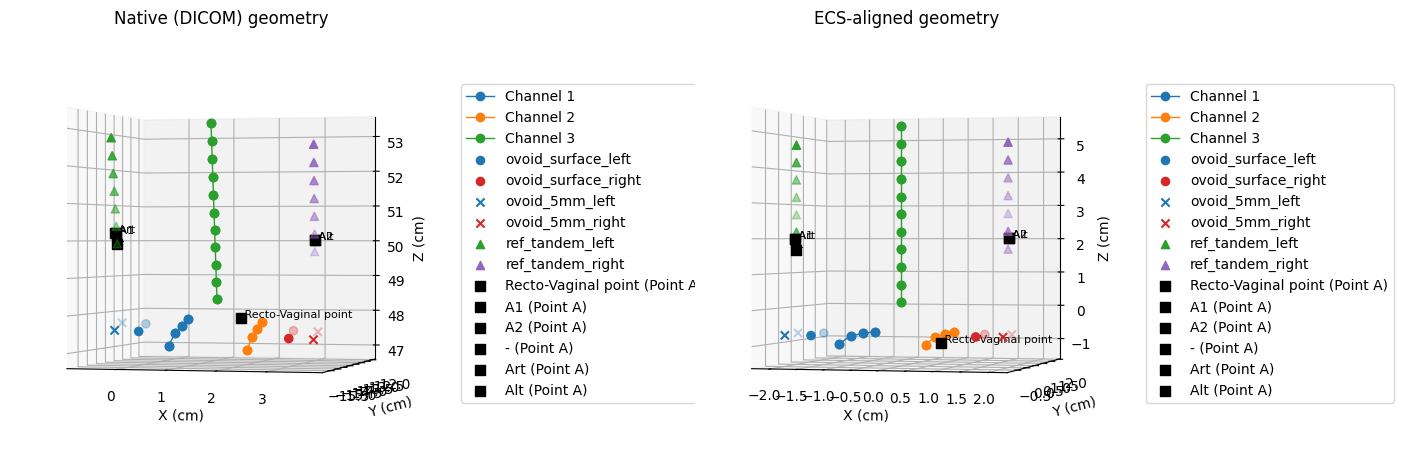

In [7]:
markers = {
    'ovoid_surface_left': ('o', '#1f77b4'),
    'ovoid_surface_right': ('o', '#d62728'),
    'ovoid_5mm_left': ('x', '#1f77b4'),
    'ovoid_5mm_right': ('x', '#d62728'),
    'ref_tandem_left': ('^', '#2ca02c'),
    'ref_tandem_right': ('^', '#9467bd'),
}


def plot_geometry(ax, channels, ref_sets, ref_points, title):
    for channel in channels:
        pts = [p for p in channel.positions_cm if p is not None]
        if not pts:
            continue
        arr = np.asarray(pts, dtype=float)
        ax.plot(arr[:, 0], arr[:, 1], arr[:, 2], marker='o', linewidth=1.0, label=f"Channel {channel.channel_number}")

    for label, pts in ref_sets.items():
        arr = np.asarray(pts, dtype=float)
        if arr.size == 0:
            continue
        marker, color = markers.get(label, ('x', 'black'))
        ax.scatter(arr[:, 0], arr[:, 1], arr[:, 2], s=35, marker=marker, color=color, label=label)

    if ref_points:
        for name, point in ref_points.items():
            arr = np.asarray(point, dtype=float)
            ax.scatter(arr[0], arr[1], arr[2], marker='s', s=45, color='black', label=f"{name} (Point A)")
            ax.text(arr[0], arr[1], arr[2], f" {name}", fontsize=8)

    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')
    ax.set_title(title)
    ax.view_init(elev=0, azim=-75, roll=0)
    try:
        ax.set_box_aspect([1, 1, 1])
    except AttributeError:
        pass
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')


fig = plt.figure(figsize=(14, 6))
ax_native = fig.add_subplot(121, projection='3d')
plot_geometry(ax_native, rt_channels, reference_sets, reference_points_native, 'Native (DICOM) geometry')
ax_ecs = fig.add_subplot(122, projection='3d')
plot_geometry(ax_ecs, rt_channels_ecs, reference_sets_ecs, reference_points_ecs, 'ECS-aligned geometry')
plt.tight_layout()
plt.show()


In [8]:
tables = dosecal.load_nucletron_tg43_tables(
    cfg["hyperparams"]["anisotropy_table"],
    cfg["hyperparams"]["radial_table"],
)
dwells, _ = dosecal.dwells_from_records(rt_channels)
channel_map = dataloader.map_channel_dwell_indices(rt_channels, dwells)
required_channels = ("ovoid_left", "ovoid_right", "tandem")
if len(channel_map) < len(required_channels):
    raise ValueError("Not enough channels found for T&O optimisation.")

dwell_indices: List[int] = []
dwell_records: List[Dict[str, Any]] = []
for channel_idx, label in enumerate(required_channels):
    indices = channel_map[channel_idx]
    channel = rt_channels[channel_idx]
    for local_idx, dwell_idx in enumerate(indices):
        dwell_indices.append(dwell_idx)
        dwell_records.append({
            "channel_label": label,
            "channel_number": channel.channel_number,
            "local_index": local_idx,
        })

opt_dwells = [dwells[i] for i in dwell_indices]
baseline_times = np.array([d.dwell_time_s for d in opt_dwells], dtype=float)
constraint_groups, _ = build_reference_constraints(
    reference_sets, opt_dwells, tables, prescription_dose_cgy
)
total_constraint_rows = int(sum(group_data["matrix"].shape[0] for group_data in constraint_groups.values()))
print(f"Optimising {len(opt_dwells)} dwell positions with {total_constraint_rows} reference rows")

Optimising 38 dwell positions with 22 reference rows


In [9]:
delta = cp.Variable(baseline_times.shape[0])
updated_times = baseline_times + delta
constraints = [updated_times >= 0]

def _group_data(name: str) -> Dict[str, Any]:
    return constraint_groups.get(
        name,
        {
            "matrix": np.zeros((0, baseline_times.shape[0])),
            "target": None,
            "rows": [],
        },
    )

tandem_group = _group_data("tandem")
ovoid_surface_group = _group_data("ovoid_surface")
ovoid_5mm_group = _group_data("ovoid_5mm")

if tandem_group["matrix"].size and tandem_group["target"] is not None:
    constraints.append(tandem_group["matrix"] @ updated_times >= tandem_group["target"])
if ovoid_surface_group["matrix"].size and ovoid_surface_group["target"] is not None:
    constraints.append(ovoid_surface_group["matrix"] @ updated_times <= ovoid_surface_group["target"])
if ovoid_5mm_group["matrix"].size:
    doses_cgy = ovoid_5mm_group["matrix"] @ updated_times
    doses_gy = doses_cgy / 100.0
    eqd2_bt_expr = bt_eqd2_scale * (cp.square(doses_gy) + alpha_beta_gy * doses_gy)
    eqd2_limits = np.full(eqd2_bt_expr.shape, eqd2_allowable_bt_gy, dtype=float)
    constraints.append(eqd2_bt_expr <= eqd2_limits)

objective = cp.Minimize(cp.sum_squares(delta))
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.SCS, warm_start=True)
print(f"Solver status: {prob.status}, objective: {prob.value:.4f}")
if prob.status not in ("optimal", "optimal_inaccurate"):
    raise RuntimeError("Convex optimisation failed to find a feasible solution.")
optimised_times = np.maximum(np.asarray(updated_times.value, dtype=float).ravel(), 0)

Solver status: optimal, objective: 169.1885


In [10]:
dwell_summary = pd.DataFrame(dwell_records)
dwell_summary["plan_time_s"] = baseline_times
dwell_summary["optimised_time_s"] = optimised_times
dwell_summary["delta_s"] = dwell_summary["optimised_time_s"] - dwell_summary["plan_time_s"]
plan_vals = dwell_summary["plan_time_s"].to_numpy()
with np.errstate(divide="ignore", invalid="ignore"):
    percent = np.where(
        np.abs(plan_vals) > 1e-6,
        dwell_summary["delta_s"] / dwell_summary["plan_time_s"],
        np.nan,
    )
dwell_summary["percent_change"] = percent

reference_rows_expanded: List[Dict[str, Any]] = []
for group_name, group_data in constraint_groups.items():
    matrix = group_data["matrix"]
    if not matrix.size:
        continue
    plan_doses = matrix @ baseline_times
    opt_doses = matrix @ optimised_times
    for idx, meta in enumerate(group_data["rows"]):
        record = dict(meta)
        record["plan_dose_cgy"] = plan_doses[idx]
        record["optimised_dose_cgy"] = opt_doses[idx]
        if group_name == "ovoid_5mm":
            plan_dose_gy = plan_doses[idx] / 100.0
            opt_dose_gy = opt_doses[idx] / 100.0
            plan_eqd2_bt = bt_eqd2_scale * (plan_dose_gy ** 2 + alpha_beta_gy * plan_dose_gy)
            opt_eqd2_bt = bt_eqd2_scale * (opt_dose_gy ** 2 + alpha_beta_gy * opt_dose_gy)
            record["plan_eqd2_total_gy"] = plan_eqd2_bt + eqd2_ebrt_gy
            record["optimised_eqd2_total_gy"] = opt_eqd2_bt + eqd2_ebrt_gy
            record["limit_eqd2_total_gy"] = eqd2_limit_total_gy
            record["slack_eqd2_gy"] = eqd2_limit_total_gy - record["optimised_eqd2_total_gy"]
            record["slack_cgy"] = np.nan
        else:
            record["plan_eqd2_total_gy"] = np.nan
            record["optimised_eqd2_total_gy"] = np.nan
            record["limit_eqd2_total_gy"] = np.nan
            record["slack_eqd2_gy"] = np.nan
            target_val = record.get("target_dose_cgy", np.nan)
            if np.isfinite(target_val):
                record["slack_cgy"] = record["optimised_dose_cgy"] - target_val
            else:
                record["slack_cgy"] = np.nan
        reference_rows_expanded.append(record)

if reference_rows_expanded:
    reference_report = pd.DataFrame(reference_rows_expanded)
else:
    reference_report = pd.DataFrame(columns=[
        "group", "subset", "point_index", "point_cm", "constraint_kind",
        "target_dose_cgy", "plan_dose_cgy", "optimised_dose_cgy", "slack_cgy",
        "plan_eqd2_total_gy", "optimised_eqd2_total_gy", "limit_eqd2_total_gy", "slack_eqd2_gy",
    ])
reference_report

,group,subset,point_index,point_cm,constraint_kind,target_dose_cgy,plan_dose_cgy,optimised_dose_cgy,plan_eqd2_total_gy,optimised_eqd2_total_gy,limit_eqd2_total_gy,slack_eqd2_gy,slack_cgy
0,ovoid_surface,ovoid_surface_left,0,"[-0.19470930047923674, -13.871029913135427, 47...",upper_bound,840.0,895.174306,840.000018,NaN,NaN,NaN,NaN,1.796341e-05
1,ovoid_surface,ovoid_surface_left,1,"[-0.1827047004792367, -14.334667713135428, 47....",upper_bound,840.0,876.698151,830.282983,NaN,NaN,NaN,NaN,-9.717017e+00
2,ovoid_surface,ovoid_surface_right,0,"[2.852095700479237, -13.654587386864575, 47.51...",upper_bound,840.0,900.026109,839.999996,NaN,NaN,NaN,NaN,-4.273454e-06
3,ovoid_surface,ovoid_surface_right,1,"[2.8826125004792367, -14.117005386864575, 47.3...",upper_bound,840.0,882.611966,832.136028,NaN,NaN,NaN,NaN,-7.863972e+00
4,ovoid_5mm,ovoid_5mm_left,0,"[-0.6927486341320612, -13.906399655225712, 47....",eqd2_upper,NaN,522.066069,510.358106,86.117280,84.557283,85.0,0.442717,NaN
5,ovoid_5mm,ovoid_5mm_left,1,"[-0.6807440341320612, -14.370037455225713, 47....",eqd2_upper,NaN,511.917177,502.053139,84.763435,83.467330,85.0,1.532670,NaN
6,ovoid_5mm,ovoid_5mm_right,0,"[3.3501350341320615, -13.61921764477429, 47.48...",eqd2_upper,NaN,525.900625,512.629756,86.634165,84.857819,85.0,0.142181,NaN
7,ovoid_5mm,ovoid_5mm_right,1,"[3.380651834132061, -14.08163564477429, 47.302...",eqd2_upper,NaN,516.541413,505.218648,85.377746,83.881148,85.0,1.118852,NaN
8,tandem,ref_tandem_left,0,"[-0.22384743461129797, -15.782734568361137, 52...",lower_bound,600.0,489.318294,602.216443,NaN,NaN,NaN,NaN,2.216443e+00
9,tandem,ref_tandem_left,1,"[-0.2629895346112976, -15.621503268361138, 52....",lower_bound,600.0,533.975844,651.790024,NaN,NaN,NaN,NaN,5.179002e+01


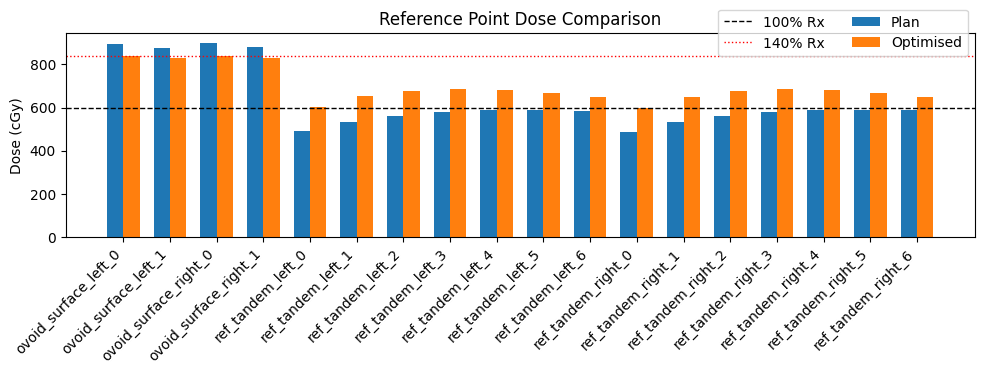

,subset,point_index,plan_EQD2_total_Gy,optimised_EQD2_total_Gy,limit_EQD2_total_Gy
4,ovoid_5mm_left,0,86.117280,84.557283,85.0
5,ovoid_5mm_left,1,84.763435,83.467330,85.0
6,ovoid_5mm_right,0,86.634165,84.857819,85.0
7,ovoid_5mm_right,1,85.377746,83.881148,85.0


In [11]:
if reference_report.empty:
    print('No reference dose data available for plotting.')
else:
    dose_df = reference_report[reference_report['constraint_kind'] != 'eqd2_upper'].copy()
    if dose_df.empty:
        print('No linear dose constraints to plot.')
    else:
        dose_df['label'] = dose_df['subset'] + '_' + dose_df['point_index'].astype(str)
        x = np.arange(len(dose_df))
        width = 0.35
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.bar(x - width/2, dose_df['plan_dose_cgy'], width, label='Plan')
        ax.bar(x + width/2, dose_df['optimised_dose_cgy'], width, label='Optimised')
        ax.axhline(prescription_dose_cgy, color='k', linestyle='--', linewidth=1.0, label='100% Rx')
        ax.axhline(prescription_dose_cgy * 1.4, color='r', linestyle=':', linewidth=1.0, label='140% Rx')
        ax.set_xticks(x)
        ax.set_xticklabels(dose_df['label'], rotation=45, ha='right')
        ax.set_ylabel('Dose (cGy)')
        ax.set_title('Reference Point Dose Comparison')
        ax.legend(ncol=2, bbox_to_anchor=(1.0, 1.15))
        plt.tight_layout()
        plt.show()

    eqd_df = reference_report[reference_report['constraint_kind'] == 'eqd2_upper'][[
        'subset', 'point_index', 'plan_eqd2_total_gy', 'optimised_eqd2_total_gy', 'limit_eqd2_total_gy'
    ]]
    if not eqd_df.empty:
        display(eqd_df.rename(columns={
            'plan_eqd2_total_gy': 'plan_EQD2_total_Gy',
            'optimised_eqd2_total_gy': 'optimised_EQD2_total_Gy',
            'limit_eqd2_total_gy': 'limit_EQD2_total_Gy',
        }))

In [12]:
def expand_channel_dwell_times(channel, candidate_times, *, atol_cm: float = 1e-3):
    """Return dwell times aligned with the RTPLAN channel layout.

    Optimisation steps can drop duplicate dwell positions, so this function
    re-inserts zero-duration placeholders whenever consecutive control points
    share the same coordinates (within ``atol_cm``).
    """
    positions = [np.asarray(p, dtype=float) for p in channel.positions_cm if p is not None]
    candidate = np.asarray(candidate_times, dtype=float)
    if not positions:
        empty = np.zeros((0,), dtype=float)
        return empty, empty.astype(bool)

    duplicate_mask = np.zeros(len(positions), dtype=bool)
    if candidate.size == len(positions):
        return candidate.copy(), duplicate_mask

    expanded = []
    idx = 0
    prev = None
    for pos_idx, pos in enumerate(positions):
        if prev is not None:
            expanded.append(0.0)
            duplicate_mask[pos_idx] = True
            continue
        if idx >= candidate.size:
            raise ValueError("Optimised dwell list shorter than channel topology.")
        expanded.append(float(candidate[idx]))
        idx += 1
        prev = pos
    if idx != candidate.size:
        raise ValueError("Optimised dwell list longer than channel topology.")
    return np.asarray(expanded, dtype=float), duplicate_mask


In [13]:
dwell_summary_sorted = dwell_summary.sort_values(["channel_label", "local_index"]).reset_index(drop=True)
updated_dwells = copy.deepcopy(dwells)
applied_rows = []
duplicate_report: Dict[str, int] = {}

for channel_idx, label in enumerate(required_channels):
    channel = rt_channels[channel_idx]
    indices = channel_map[channel_idx]
    candidate = dwell_summary_sorted.loc[
        dwell_summary_sorted["channel_label"] == label,
        "optimised_time_s",
    ].to_numpy()
    expanded_times, duplicate_mask = expand_channel_dwell_times(channel, candidate, atol_cm=1e-4)
    if expanded_times.size != len(indices):
        raise ValueError(
            f"Expanded dwell schedule for {label} has {expanded_times.size} entries, "
            f"but the RTPLAN channel expects {len(indices)}."
        )
    duplicate_report[label] = int(duplicate_mask.sum())
    for local_idx, (dwell_idx, new_time, is_dup) in enumerate(zip(indices, expanded_times, duplicate_mask)):
        baseline_time = dwells[dwell_idx].dwell_time_s
        new_time = float(new_time)
        updated_dwells[dwell_idx].dwell_time_s = new_time
        applied_rows.append({
            "channel_label": label,
            "channel_number": channel.channel_number,
            "local_index": local_idx,
            "dwell_index": dwell_idx,
            "is_duplicate": bool(is_dup),
            "plan_time_s": baseline_time,
            "optimised_time_s": new_time,
            "delta_s": new_time - baseline_time,
        })

scaled_channels = dosecal.rebuild_channels(rt_channels_ecs, updated_dwells)

print("Restored duplicate dwell placeholders per channel:")
for label in required_channels:
    print(f"  {label}: {duplicate_report.get(label, 0)}")

applied_dwell_summary = pd.DataFrame(applied_rows)
applied_dwell_summary


Restored duplicate dwell placeholders per channel:
  ovoid_left: 0
  ovoid_right: 0
  tandem: 0


,channel_label,channel_number,local_index,dwell_index,is_duplicate,plan_time_s,optimised_time_s,delta_s
0,ovoid_left,1,0,0,False,0.000000,0.000000e+00,0.000000e+00
1,ovoid_left,1,1,1,False,8.294523,7.270978e+00,-1.023545e+00
2,ovoid_left,1,2,2,False,0.000000,0.000000e+00,0.000000e+00
3,ovoid_left,1,3,3,False,8.294523,6.629173e+00,-1.665349e+00
4,ovoid_left,1,4,4,False,0.000000,0.000000e+00,0.000000e+00
5,ovoid_left,1,5,5,False,8.294523,7.209214e+00,-1.085309e+00
6,ovoid_left,1,6,6,False,0.000000,1.101847e-08,1.101847e-08
7,ovoid_left,1,7,7,False,8.294523,7.793905e+00,-5.006171e-01
8,ovoid_right,2,0,8,False,0.000000,3.060012e-07,3.060012e-07
9,ovoid_right,2,1,9,False,8.294523,7.195192e+00,-1.099330e+00


600 [ 300.  600. 1200.]


/tmp/ipykernel_18045/2633705334.py:71: UserWarning: You passed a edgecolor/edgecolors ('#ffffff') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(coords_art[:, 0]-display_offet, coords_art[:, 1], s=20, marker='x', edgecolors="#ffffff", linewidths=1.5, color="#000000")
/tmp/ipykernel_18045/2633705334.py:90: UserWarning: You passed a edgecolor/edgecolors ('#ffffff') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(coords_art[:, 0]-display_offet, coords_art[:, 2], s=20, marker='x', edgecolors="#ffffff", linewidths=1.5, color="#000000")
/tmp/ipykernel_18045/2633705334.py:110: UserWarning: You passed a edgecolor/edgecolors ('#ffffff') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(coords_ar

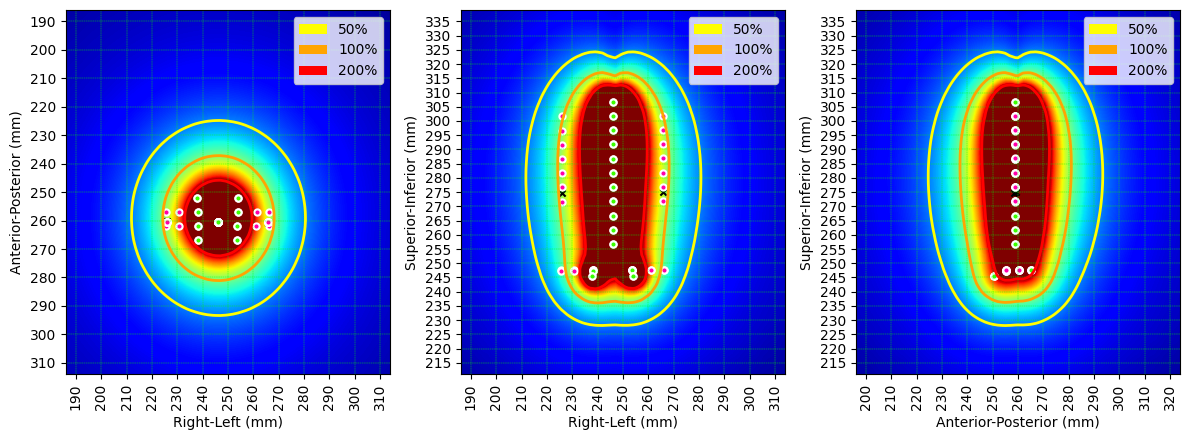

In [14]:
import importlib
importlib.reload(dhelp)

def convert_physical_to_continuous_index(ct_image, physical_mm):

    physical_mm = np.array(physical_mm, dtype=float)*10
    if len(physical_mm.shape) == 1:
        return ct_image.TransformPhysicalPointToContinuousIndex(physical_mm)
    else:
        results = []
        for idx_mm in range(physical_mm.shape[0]):
            point_mm = physical_mm[idx_mm, :]
            idx_cont = ct_image.TransformPhysicalPointToContinuousIndex(physical_mm[idx_mm, :])
            results.append(idx_cont)
        return results

coords_art = []
coords_art.append(convert_physical_to_continuous_index(ct_ecs_image, reference_points_ecs['Alt']))
coords_art.append(convert_physical_to_continuous_index(ct_ecs_image, reference_points_ecs['Art']))
coords_art = np.array(coords_art)

coords_ref = []
for name_ref in reference_sets_ecs.keys():
    coords_ref.extend(convert_physical_to_continuous_index(ct_ecs_image, reference_sets_ecs[name_ref]))
coords_ref = np.array(coords_ref)


dose_result = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=scaled_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)

dose_array = dose_result.resampled_array

x_ticks = range(ct_ecs_metadata["size"][0])
y_ticks = range(ct_ecs_metadata["size"][1])
z_ticks = range(ct_ecs_metadata["size"][2])

x_coords_mm = np.array(np.array(x_ticks) * ct_ecs_metadata["spacing"][0], dtype=int)
y_coords_mm = np.array(np.array(y_ticks) * ct_ecs_metadata["spacing"][1], dtype=int)
z_coords_mm = np.array(np.array(z_ticks) * ct_ecs_metadata["spacing"][2], dtype=int)

view_axial = dose_array[np.argmax(np.sum(dose_array, axis=(1, 2))), :, :]
view_coronal = dose_array[:, np.argmax(np.sum(dose_array, axis=(0, 2))), :]
view_sagittal = dose_array[:, :, np.argmax(np.sum(dose_array, axis=(0, 1)))]
dwell_info = dhelp.extract_dwell_positions_continuous_index(ct_ecs_image, rt_channels_ecs)
dwell_positions = np.array(dwell_info['position'])
display_offet = 1.5

vmin, vmax = 0, prescription_dose_cgy * 2
iso_levels = np.array([0.5, 1.0, 2.0]) * prescription_dose_cgy  # cGy
iso_colors = ["yellow","orange","red"]
iso_labels = ['50%', '100%', '200%']
print(prescription_dose_cgy, iso_levels)

fontsize = 8 
tick_step = 10
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.imshow(view_axial, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs1= plt.contour(view_axial, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.scatter(dwell_positions[:, 0]-display_offet, dwell_positions[:, 1], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#3cff00")
plt.scatter(coords_art[:, 0]-display_offet, coords_art[:, 1], s=20, marker='x', edgecolors="#ffffff", linewidths=1.5, color="#000000")
plt.scatter(coords_ref[:, 0]-display_offet, coords_ref[:, 1], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#FF00AA")
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
x_center = 250
y_center = 250
size_zoom = 128
plt.xlim(x_center-size_zoom//2, x_center+size_zoom//2)
plt.ylim(y_center+size_zoom//2, y_center-size_zoom//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.imshow(view_coronal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs2 = plt.contour(view_coronal, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.scatter(dwell_positions[:, 0]-display_offet, dwell_positions[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#3cff00")
plt.scatter(coords_art[:, 0]-display_offet, coords_art[:, 2], s=20, marker='x', edgecolors="#ffffff", linewidths=1.5, color="#000000")
plt.scatter(coords_ref[:, 0]-display_offet, coords_ref[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#FF00AA")
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 250
y_center = 275
size_zoom_x = 128
size_zoom_y = 128
plt.xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
plt.ylim(y_center-size_zoom_y//2, y_center+size_zoom_y//2)
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.imshow(view_sagittal, interpolation='bilinear', aspect="auto", cmap="jet", vmin=vmin, vmax=vmax)
cs3= plt.contour(view_sagittal, levels=iso_levels, colors=iso_colors, linewidths=2.0)
proxy = [plt.Rectangle((0,0),1,1, fc=iso_color) for iso_color in iso_colors]
plt.legend(proxy, iso_labels)
plt.scatter(dwell_positions[:, 1]-display_offet, dwell_positions[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#3cff00")
plt.scatter(coords_art[:, 1]-display_offet, coords_art[:, 2], s=20, marker='x', edgecolors="#ffffff", linewidths=1.5, color="#000000")
plt.scatter(coords_ref[:, 1]-display_offet, coords_ref[:, 2], s=20, marker='o', edgecolors="#ffffff", linewidths=1.5, color="#FF00AA")
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
x_center = 260
y_center = 275
size_zoom_x = 128
size_zoom_y = 128
plt.xlim(x_center-size_zoom_x//2, x_center+size_zoom_x//2)
plt.ylim(y_center-size_zoom_y//2, y_center+size_zoom_y//2)
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

In [15]:
dose_array.max()

np.float32(57144.547)

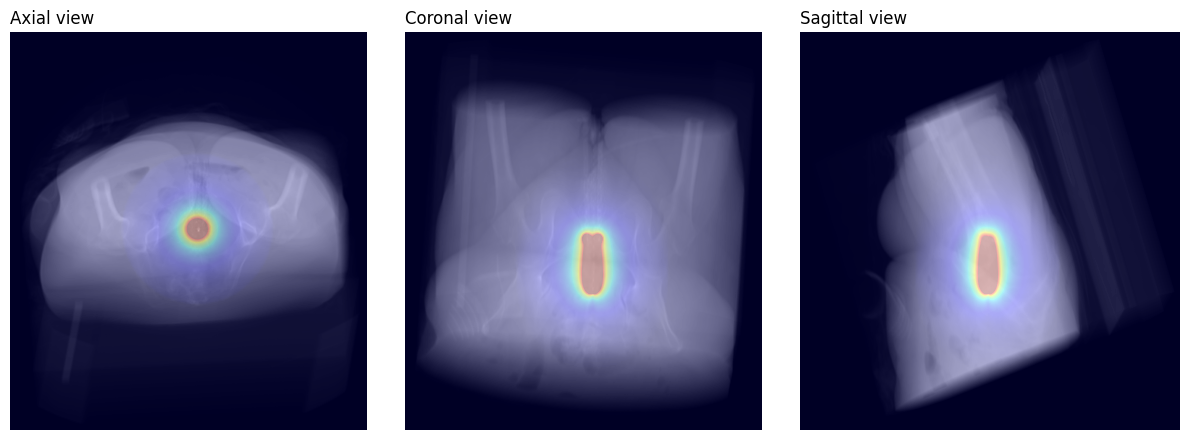

In [16]:
ct_view = ct_ecs_array
dose_result = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_ecs_image,
    channels=scaled_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)

dose_array = dose_result.resampled_array
vmin, vmax = 0, prescription_dose_cgy * 2
view_axial = dose_array[np.argmax(np.sum(dose_array, axis=(1, 2))), :, :]
view_coronal = dose_array[:, np.argmax(np.sum(dose_array, axis=(0, 2))), :]
view_sagittal = dose_array[:, :, np.argmax(np.sum(dose_array, axis=(0, 1)))]

x_ticks = range(ct_metadata["size"][0])
y_ticks = range(ct_metadata["size"][1])
z_ticks = range(ct_metadata["size"][2])

x_coords_mm = np.array(np.array(x_ticks) * ct_metadata["spacing"][0], dtype=int)
y_coords_mm = np.array(np.array(y_ticks) * ct_metadata["spacing"][1], dtype=int)
z_coords_mm = np.array(np.array(z_ticks) * ct_metadata["spacing"][2], dtype=int)

tick_step = 100
z_tick_step = max(1, tick_step // 2)
alpha = 0.3

plt.figure(figsize=(12, 4.5), dpi=100)

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Axial view", loc="left")
plt.imshow(np.sum(ct_view, axis=0), aspect="auto", cmap="gray")
plt.imshow(view_axial, aspect="auto", cmap="jet", alpha=alpha, vmin=vmin, vmax=vmax)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1))
plt.xlabel("Right-Left (mm)")
plt.ylabel("Anterior-Posterior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Coronal view", loc="left")
plt.imshow(np.sum(ct_view, axis=1), aspect="auto", cmap="gray")
plt.imshow(view_coronal, aspect="auto", cmap="jet", alpha=alpha, vmin=vmin, vmax=vmax)
plt.xticks(ticks=x_ticks[::tick_step], labels=np.round(x_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
plt.xlabel("Right-Left (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("Sagittal view", loc="left")
plt.imshow(np.sum(ct_view, axis=2), aspect="auto", cmap="gray")
plt.imshow(view_sagittal, aspect="auto", cmap="jet", alpha=alpha, vmin=vmin, vmax=vmax)
plt.xticks(ticks=y_ticks[::tick_step], labels=np.round(y_coords_mm[::tick_step], 1), rotation=90)
plt.yticks(ticks=z_ticks[::z_tick_step], labels=np.round(z_coords_mm[::z_tick_step], 1))
plt.xlabel("Anterior-Posterior (mm)")
plt.ylabel("Superior-Inferior (mm)")
plt.grid(linewidth=0.3, color="lime", linestyle="--")

plt.tight_layout()
plt.show()

In [17]:
rt_channels_updated = dosecal.rebuild_channels(rt_channels, updated_dwells)

dose_result = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels_updated,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)
dose_original = dosecal.calculate_and_resample_to_ct(
    ct_image=ct_image,
    channels=rt_channels,
    anisotropy_path=cfg['hyperparams']['anisotropy_table'],
    radial_path=cfg['hyperparams']['radial_table'],
)

In [18]:
paths["struct"]

PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')

In [19]:
import copy
import importlib
importlib.reload(chelp)
importlib.reload(rtexport)

rtstruct = chelp.load_rtstruct(paths["struct"])
slice_uid_map = rtexport.map_ct_slice_uids(
    paths["ct"],
    reference_image=ct_image,
)

case_label = getattr(case_id, "name", str(case_id)) or "case"

rtstruct_optimized = copy.copy(rtstruct)
rtstruct_optimized = rtexport.embed_mask_as_structure(
    rtstruct_optimized,
    mask=dose_result.resampled_array >= prescription_dose_cgy,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO100",
    color=(0, 176, 255),
    description=f"100% prescription ({prescription_dose_cgy} cGy) isodose",
)
rtstruct_optimized = rtexport.embed_mask_as_structure(
    rtstruct_optimized,
    mask=dose_result.resampled_array >= prescription_dose_cgy*2,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO200",
    color=(0, 176, 255),
    description=f"200% prescription ({prescription_dose_cgy} cGy) isodose",
)

rtstruct_original = copy.copy(rtstruct)
rtstruct_original = rtexport.embed_mask_as_structure(
    rtstruct_original,
    mask=dose_original.resampled_array >= prescription_dose_cgy,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO100",
    color=(255, 128, 0),
    description=f"100% prescription ({prescription_dose_cgy} cGy) isodose",
)
rtstruct_original = rtexport.embed_mask_as_structure(
    rtstruct_original,
    mask=dose_original.resampled_array >= prescription_dose_cgy*2,
    reference_image=ct_image,
    slice_uid_map=slice_uid_map,
    roi_name="ISO200",
    color=(255, 128, 0),
    description=f"200% prescription ({prescription_dose_cgy} cGy) isodose",
)

optimized_output = Path.cwd() / f"{case_label}_iso100_optimized_rtstruct.dcm"
original_output = Path.cwd() / f"{case_label}_iso100_original_rtstruct.dcm"

optimized_path = rtexport.write_rtstruct(rtstruct_optimized, optimized_output)
original_path = rtexport.write_rtstruct(rtstruct_original, original_output)

print(f"Saved optimised RTSTRUCT: {optimized_path}")
print(f"Saved baseline RTSTRUCT: {original_path}")

Saved optimised RTSTRUCT: /home/ypark6/dose_prediction/Case6_iso100_optimized_rtstruct.dcm
Saved baseline RTSTRUCT: /home/ypark6/dose_prediction/Case6_iso100_original_rtstruct.dcm


Bladder (160, 512, 512) 210.16906210327147
Rectum (160, 512, 512) 78.20387100219726
Sigmoid (160, 512, 512) 183.42243594360352
Bowel (160, 512, 512) 206.2238889770508
HR-CTV (160, 512, 512) 27.07223043823242
ISO100 (160, 512, 512) 93.29412551879882
ISO200 (160, 512, 512) 31.567923248291017


/tmp/ipykernel_18045/2682402398.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


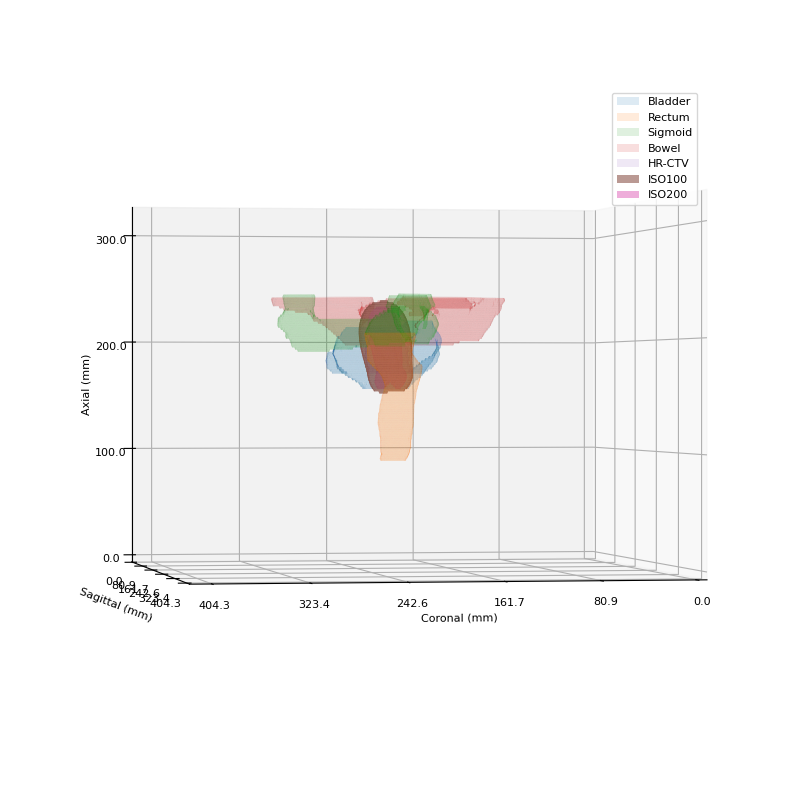

In [20]:
import matplotlib.colors as mcolors
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])
rtstruct = chelp.load_rtstruct("/home/ypark6/dose_prediction/Case6_iso100_optimized_rtstruct.dcm")

list_contour = ['Bladder', 'Rectum', 'Sigmoid', 'Bowel', 'HR-CTV', 'ISO100', 'ISO200']

list_colors = list(mcolors.TABLEAU_COLORS.values())
fontsize = 8
tickstep = 100
x_ticks = range(ct_metadata['size'][0])
y_ticks = range(ct_metadata['size'][1])
z_ticks = range(ct_metadata['size'][2])
x_mms = np.array(x_ticks)*ct_metadata['spacing'][0]
y_mms = np.array(y_ticks)*ct_metadata['spacing'][1]
z_mms = np.array(z_ticks)*ct_metadata['spacing'][2]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for idx, name in enumerate(list_contour):
    try: mask = chelp.rasterise_structure(rtstruct, name, ct_image)
    except: continue
    if mask is None: continue
    print(name, mask.shape, np.sum(mask)*np.prod(ct_metadata['spacing'])/(10**3))

    verts, faces, normals, values = measure.marching_cubes(mask.transpose(2,1,0), 0)
    if 'ISO' in name:
        alpha=0.6
    else:   
        alpha=0.15
    mesh = Poly3DCollection(verts[faces], alpha=alpha, label=name)
    mesh.set_facecolor(list_colors[idx])
    ax.add_collection3d(mesh)

ax.set_xticks(ticks=x_ticks[::tickstep], labels=np.round(x_mms[::tickstep], 1), fontsize=fontsize)
ax.set_yticks(ticks=y_ticks[::tickstep], labels=np.round(y_mms[::tickstep], 1), fontsize=fontsize)
ax.set_zticks(ticks=z_ticks[::tickstep//2], labels=np.round(z_mms[::tickstep//2], 1), fontsize=fontsize)
ax.set_xlabel('Coronal (mm)', fontsize=fontsize)
ax.set_ylabel('Sagittal (mm)', fontsize=fontsize)
ax.set_zlabel('Axial (mm)', fontsize=fontsize)
ax.set_xlim(0, ct_metadata['size'][0])
ax.set_ylim(0, ct_metadata['size'][1])
ax.set_zlim(0, ct_metadata['size'][2])

ax.view_init(elev=0, azim=80, roll=0)

plt.legend(bbox_to_anchor=(0.9, 0.9), loc='upper right', fontsize=fontsize)
plt.tight_layout()
plt.show()

Bladder (160, 512, 512) 210.16906210327147


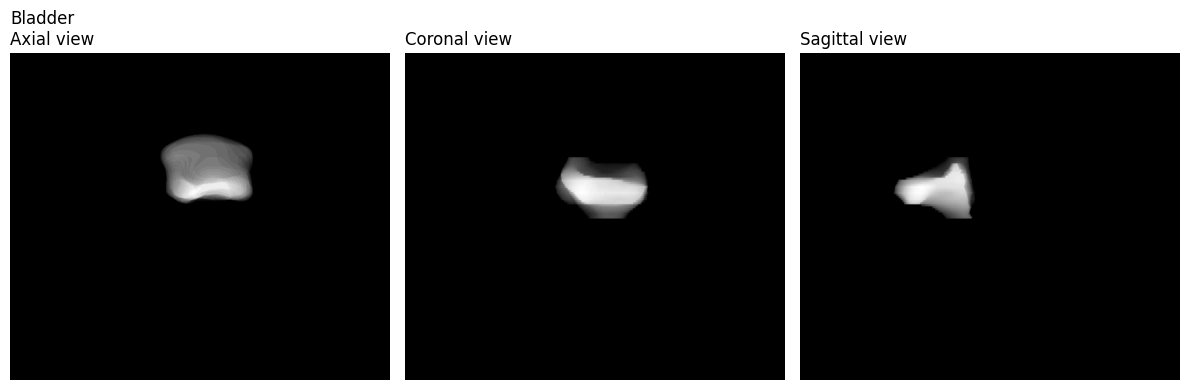

Rectum (160, 512, 512) 78.20387100219726


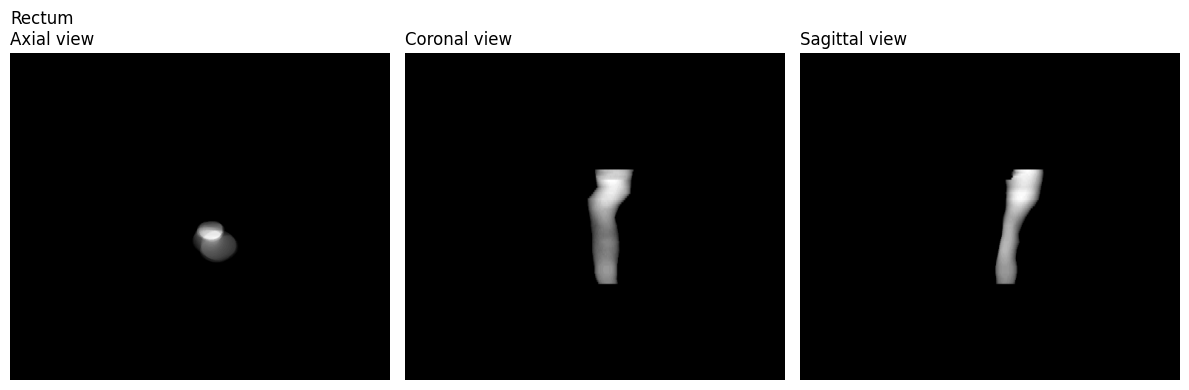

Sigmoid (160, 512, 512) 183.42243594360352


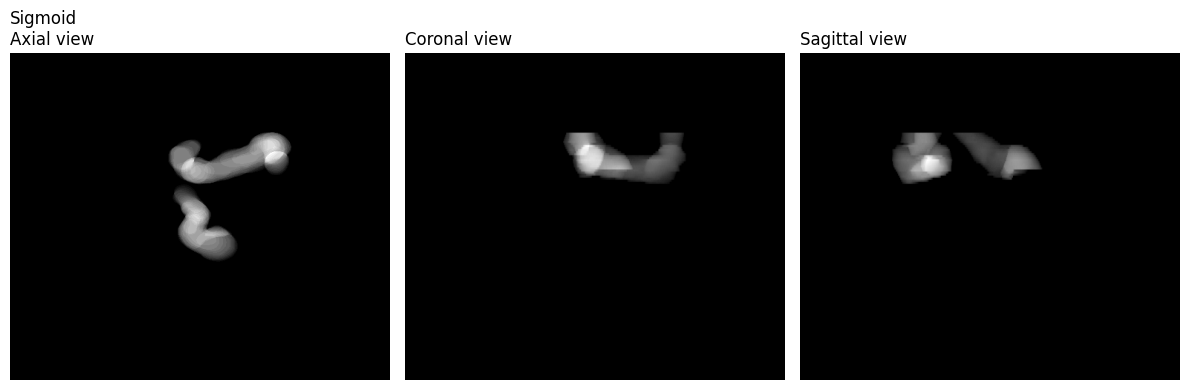

Bowel (160, 512, 512) 206.2238889770508


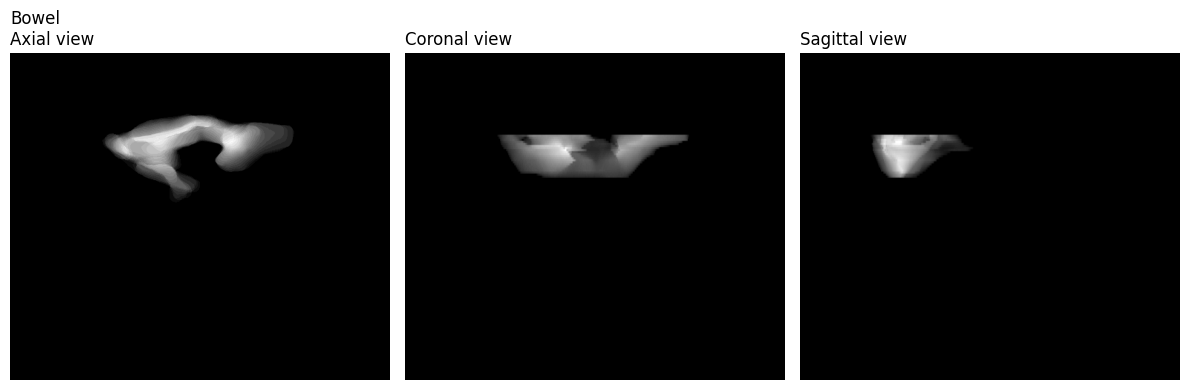

HR-CTV (160, 512, 512) 27.07223043823242


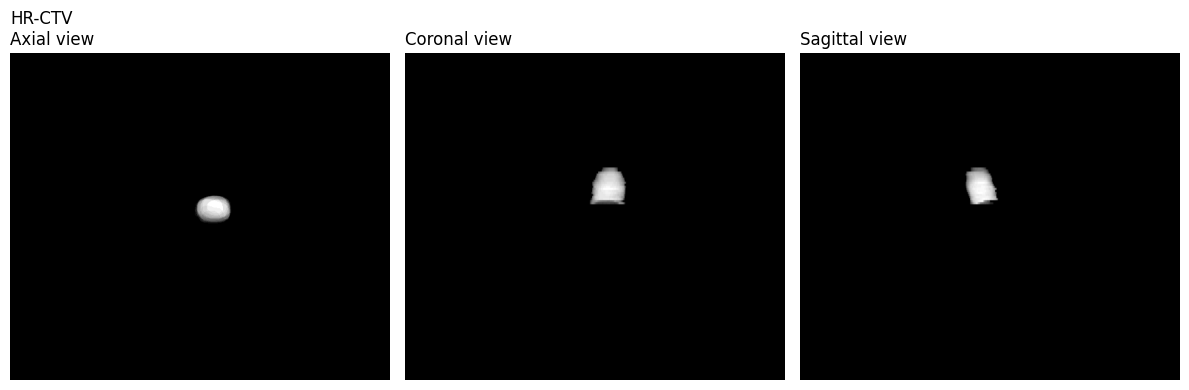

ISO100 (160, 512, 512) 93.29412551879882


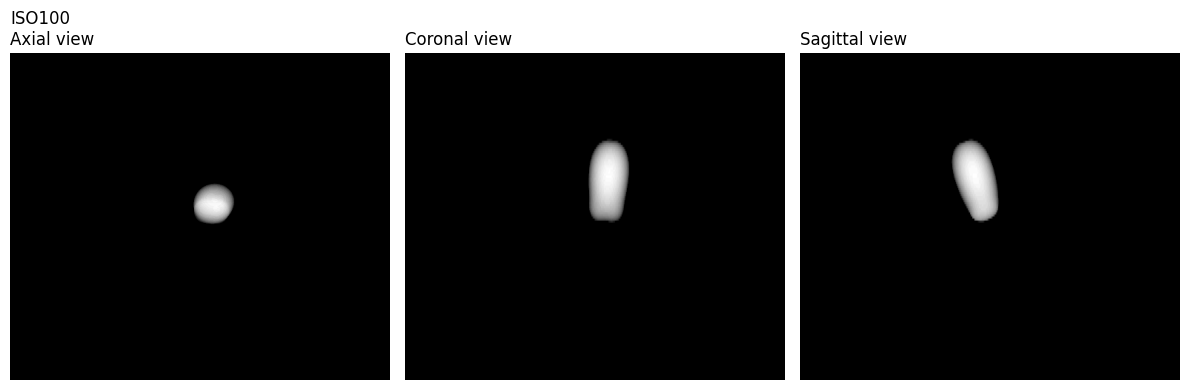

ISO200 (160, 512, 512) 31.567923248291017


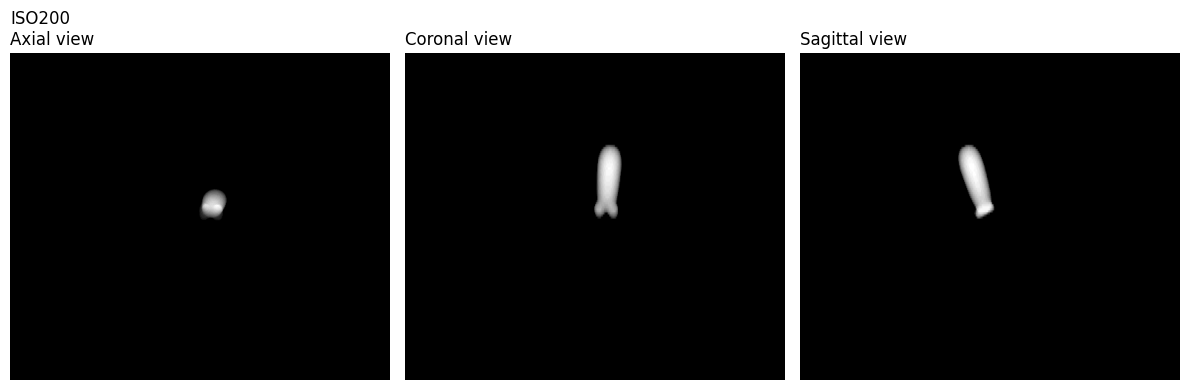

In [21]:
for idx, name in enumerate(list_contour):
    try: mask = chelp.rasterise_structure(rtstruct, name, ct_image)
    except: continue
    if mask is None: continue
    print(name, mask.shape, np.sum(mask)*np.prod(ct_metadata['spacing'])/(10**3))

    mask = mask[::-1]
    plt.figure(figsize=(12, 4), dpi=100)
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.title(f"{name}\nAxial view", loc="left")
    plt.imshow(np.sum(mask, axis=0), aspect="auto", cmap="gray")
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.title("Coronal view", loc="left")
    plt.imshow(np.sum(mask, axis=1), aspect="auto", cmap="gray")
    plt.subplot(1, 3, 3)
    plt.axis('off')
    plt.title("Sagittal view", loc="left")
    plt.imshow(np.sum(mask, axis=2), aspect="auto", cmap="gray")
    plt.tight_layout()
    plt.show()

In [22]:
case_label = globals().get("case_label") or getattr(case_id, "name", str(case_id)) or "case"
rtplan_output = Path.cwd() / f"{case_label}_optimized_rtplan.dcm"
dhelp.save_rtplan_with_channels(
    template_path=paths["plan"],
    output_path=rtplan_output,
    channels=rt_channels_updated,
    update_uids=True,
    anonymization=True,
)
print(f"Saved optimised RTPLAN: {rtplan_output}")


Saved optimised RTPLAN: /home/ypark6/dose_prediction/Case6_optimized_rtplan.dcm


/home/ypark6/.uvenv/lib/python3.12/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR DA: 'Anonymized'.
  warn_and_log(msg)
/home/ypark6/.uvenv/lib/python3.12/site-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR CS: 'Anonymized'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
